In [16]:
!pip install matplotlib numpy tensorboard standard-imghdr


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [17]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from PIL import Image, ImageDraw, ImageFont
from ImageToStringNet import ImageToStringNet, classes

In [18]:
print("Classes: ", len(classes))

class DigitDataset(Dataset):
    def __init__(self, imgs_path, txt_path, transform=None):
        self.imgs_path = imgs_path
        self.images = np.loadtxt(txt_path, dtype=str, delimiter='\t', comments=[])
        self.transform = transform
        self.targets = [classes.index(c) for _, c, _, _ in self.images]
        self.targets = torch.LongTensor(self.targets)
        
        self.data = [Image.open(f'{self.imgs_path}/{i}').convert('L') for i, _, _, _ in self.images]
        self.data = [self.transform(i) for i in self.data]
        self.data = torch.stack(self.data, dim=0)

    def __getitem__(self, index):
        _, _, t, b = self.images[index]

        # Image Tensor, Label, Top Margin (%), Bottom Margin (%)
        return self.data[index], self.targets[index], np.float32(t), np.float32(b)

    def __len__(self):
        return len(self.images)

Classes:  96


In [19]:

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

dataset_dir = "../dataset/digit_dataset"
trainset = DigitDataset(imgs_path=dataset_dir, txt_path="../dataset/digit_dataset/train.txt", transform=transforms.ToTensor())
testset = DigitDataset(imgs_path=dataset_dir, txt_path="../dataset/digit_dataset/test.txt", transform=transforms.ToTensor())

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [20]:
net = ImageToStringNet()

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/exp1')

In [23]:
dataiter = iter(trainloader)
next(dataiter)[0].shape

torch.Size([4, 1, 28, 28])

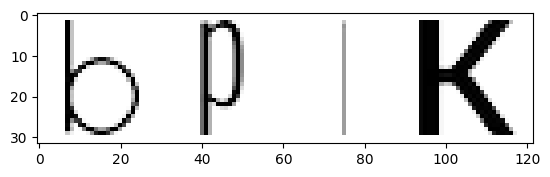

In [24]:
# get some random training images
dataiter = iter(trainloader)
images, labels, t, b = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_img-to-str_images', img_grid)

tensorboard --logdir=runs

In [25]:
writer.add_graph(net, (images, t, b))
writer.close()

In [26]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

Images shape:  torch.Size([100, 1, 28, 28])
Labels shape:  torch.Size([100])


In [27]:
# helper functions

def images_to_probs(net, images, top_margin, bottom_margin):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images, top_margin, bottom_margin)
    # convert output probabilities to predicted class

    output = output.cpu()

    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, top_margin, bottom_margin):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images, top_margin, bottom_margin)
    # plot the images in the batch, along with predicted and true labels

    images = images.cpu()

    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [28]:
if torch.xpu.is_available():
    net = net.xpu()

In [29]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, t, b = data
        inputs, labels, t, b = inputs.xpu(), labels.xpu(), t.xpu(), b.xpu()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs, t, b)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels, t, b),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [30]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels, t, b = data

        if torch.xpu.is_available():
            images, t, b = images.xpu(), t.xpu(), b.xpu()

        output = net(images, t, b)

        output = output.cpu()

        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

In [31]:
torch.save(net.state_dict(), 'model_weights.pth')

# ---

In [32]:
import torch

if torch.xpu.is_available():
    print("Using Intel GPU (XPU)")
else:
    print("No supported GPU backend detected")

Using Intel GPU (XPU)


In [33]:
import torch.nn as nn
import torch.nn.functional as F

conv1 = nn.Conv2d(1, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
fc1 = nn.Linear(16 * 4 * 4, 120)
fc2 = nn.Linear(120, 84)
fc3 = nn.Linear(84, 10)

In [34]:
trainloader.dataset

In [35]:
img = torch.rand(1,28,28)
x = conv1(img)
print("conv1:",x.shape)

x = F.relu(x)
print("F.relu:",x.shape)

x = pool(x)
print("pool:",x.shape)

x = conv2(x)
print("conv2:",x.shape)

x = F.relu(x)
print("F.relu:",x.shape)

x = pool(x)
print("pool:",x.shape)

x.view(-1, 16 * 4 * 4).shape

conv1: torch.Size([6, 24, 24])
F.relu: torch.Size([6, 24, 24])
pool: torch.Size([6, 12, 12])
conv2: torch.Size([16, 8, 8])
F.relu: torch.Size([16, 8, 8])
pool: torch.Size([16, 4, 4])


torch.Size([1, 256])